# 0. import 


In [1]:
import json
import xml.etree.ElementTree as ElementTree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests

from IOHandler import *
%matplotlib widget

## configure
> configure here what you need 

In [2]:
# read key from key.json file
PUBLIC_DATA_API_KEY = str(json.loads(open("key.json").read())["LX"])
SRS_NAME = "EPSG:5179"
MAP_NAME = "LX_test"

In [3]:
proj = pyproj.Proj(SRS_NAME)


In [4]:
# left_bottom_lonlat = (126.97999191237074, 37.55913710608509)
# right_top_lonlat = (126.9851453896948, 37.56312770042335)
# left_bottom_lonlat = (126.979, 37.559)
left_bottom_lonlat = (127.35953075456467,36.36306752736285)
# right_top_lonlat = (126.980, 37.560)
right_top_lonlat = (127.36624087402176 ,36.37701626640067)

# 1. pull data

## 1-1. pull

In [5]:
GIS_BUILDING_SERVICE_WFS = 'https://apis.data.go.kr/1611000/nsdi/GisBuildingService/wfs/getGisGnrlBuildingWFS'
TYPE_NAME = "F171"
MAX_FEATURES = "100"
RESULT_TYPE = "results"
bbox_epsg = ','.join(map(str, [*proj(*left_bottom_lonlat), *proj(*right_top_lonlat)]))
params = {
    'serviceKey' : PUBLIC_DATA_API_KEY,
    'typename' : TYPE_NAME,
    'bbox' : bbox_epsg + ',' + SRS_NAME,
    'maxFeatures' : MAX_FEATURES,
    'resultType' : RESULT_TYPE,
    'srsName' : SRS_NAME
}

response = requests.get(GIS_BUILDING_SERVICE_WFS, params=params)
response_text = response.content.decode()
tree = ElementTree.ElementTree(ElementTree.fromstring(response_text))

## 2. parsing

In [6]:
xmlns = dict()
for elem in response_text.split('>')[1].split('xmlns')[1:]:
    text = elem[1:].split(' ')[0]
    key, item = text.split('=')
    xmlns[key] = item.replace('"', '')
xmlns

{'xs': 'http://www.w3.org/2001/XMLSchema',
 'wfs': 'http://www.opengis.net/wfs',
 'gml': 'http://www.opengis.net/gml',
 'NSDI': 'http://10.1.17.66:6080/arcgis/services/opend/EiosSpceServiceWFS/MapServer/WFSServer',
 'xlink': 'http://www.w3.org/1999/xlink',
 'xsi': 'http://www.w3.org/2001/XMLSchema-instance'}

In [7]:
def remove_ns(tag):
    return tag.split('}')[-1]

In [8]:
df = pd.DataFrame(columns=['bldg_id', 'bldg_name', 'bldg_hg',
                  'ground_floor_co', 'undgrnd_floor_co', 'frst_regist_dt', 'shape'])
for bldg in tree.findall(f'.//gml:featureMember/NSDI:{TYPE_NAME}', xmlns):
    #     print(remove_ns(bldg.tag))

    #     bldg_id = bldg.attrib[f'{{{xmlns["gml"]}}}id']
    bldg_id = bldg.find('NSDI:GIS_IDNTFC_NO', xmlns).text
#     bldg_id = bldg.find('NSDI:BULD_IDNTFC_NO', xmlns).text
    print('bldg_id:', bldg_id)

    bldg_name = bldg.find('NSDI:BULD_NM', xmlns).text
    print('bldg_name:', bldg_name)

    bldg_hg = float(bldg.find('NSDI:BULD_HG', xmlns).text)
    print('bldg_hg:', bldg_hg)

    ground_floor_co = float(bldg.find('NSDI:GROUND_FLOOR_CO', xmlns).text)
    print('ground_floor_co:', ground_floor_co)

    undgrnd_floor_co = float(bldg.find('NSDI:UNDGRND_FLOOR_CO', xmlns).text)
    print('undgrnd_floor_co:', undgrnd_floor_co)

    frst_regist_dt = bldg.find('NSDI:FRST_REGIST_DT', xmlns).text
    print('frst_regist_dt:', frst_regist_dt)

    shape = bldg.find('NSDI:SHAPE//gml:posList', xmlns).text
    values = list(map(float, shape.split(' ')))
    print(values[::2], values[1::2])
    # print('shape:', shape)
    new_row = pd.DataFrame({
        'bldg_id': bldg_id,
        'bldg_name': bldg_name,
        'bldg_hg': bldg_hg,
        'ground_floor_co': ground_floor_co,
        'undgrnd_floor_co': undgrnd_floor_co,
        'frst_regist_dt': frst_regist_dt,
        'values': [str(values)]
    })
    df = pd.concat([df, new_row])
    print('-'*100)

df.to_csv(MAP_NAME+'.csv', index=False)


bldg_id: 2003232005343195924300000000
bldg_name: 한국생명공학연구원
bldg_hg: 4.0
ground_floor_co: 1.0
undgrnd_floor_co: 0.0
frst_regist_dt: 2023-09-18T13:35:24
[987395.8546497358, 987399.2434892383, 987414.849130177, 987414.839027161, 987414.8142068564, 987410.5636658213, 987399.1985741039, 987395.8197315586, 987395.8546497358] [1819596.885459746, 1819596.843029917, 1819596.644766204, 1819595.847050431, 1819593.937734013, 1819593.991595636, 1819594.137048801, 1819594.179427184, 1819596.885459746]
----------------------------------------------------------------------------------------------------
bldg_id: 1994232101053196722300000000
bldg_name: 한국생명공학연구원
bldg_hg: 14.0
ground_floor_co: 3.0
undgrnd_floor_co: 1.0
frst_regist_dt: 2023-09-18T13:35:24
[987474.9332535868, 987485.863502523, 987487.9827695468, 987487.9089373456, 987512.6174488832, 987513.7670523861, 987513.7116808315, 987519.5116876356, 987519.567059187, 987548.5181127077, 987548.4951149477, 987548.3036860959, 987548.2075679592, 987516.6

/tmp/ipykernel_3744067/1063243411.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])


# 2. Convert to Numpy array

In [9]:
df = pd.read_csv('LX_test.csv')

polygon = df['values'].tolist()
mapInHeight = df['bldg_hg'].tolist()
for i in range(len(polygon)):
    polygon[i] = np.array(eval(polygon[i])).reshape(-1, 2)
maparray = poly2numpy(polygon,heights=mapInHeight)

np.save(MAP_NAME+'.npy', maparray)


bottom:  987348.4169762174
left:    1818300.386440567
top:     988119.5412749264
right:   1819973.889097789


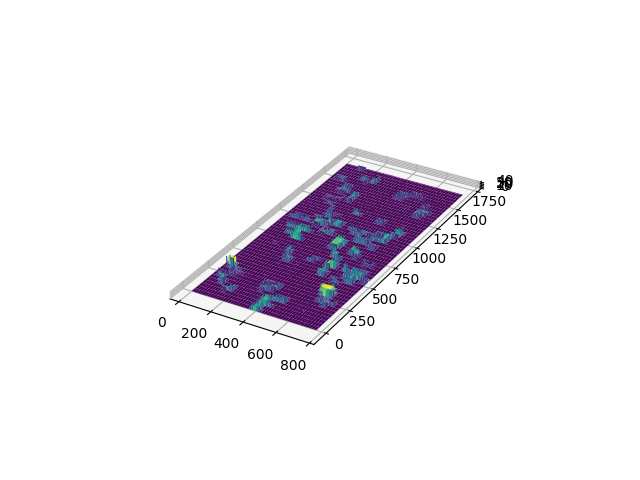

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

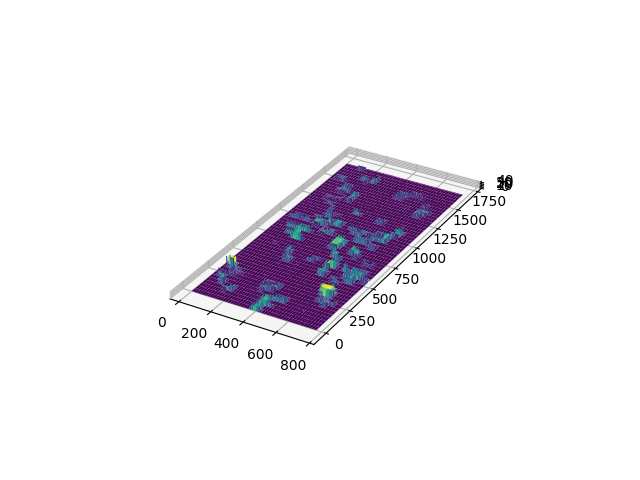

In [10]:
plot3dMap(maparray)

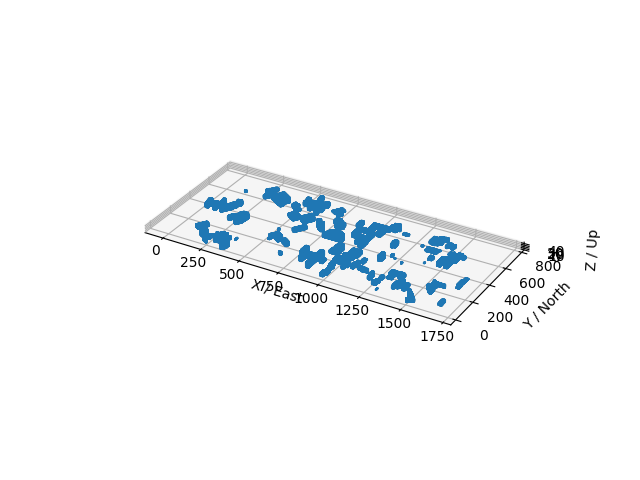

In [11]:
# This Takes a lot of time to rotate in 3D

map3d = mapHeightTo3D(maparray)
# find the map3d where is 1 
x, y, z = np.where(map3d == 1)
# plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, zdir='z', s=0.1,alpha=0.3)
ax.set_xlabel('X / East')
ax.set_ylabel('Y / North')
ax.set_zlabel('Z / Up')
ax.set_aspect('equal')

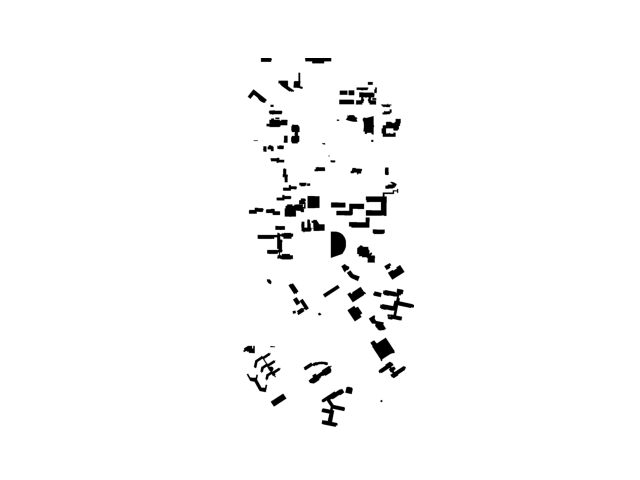

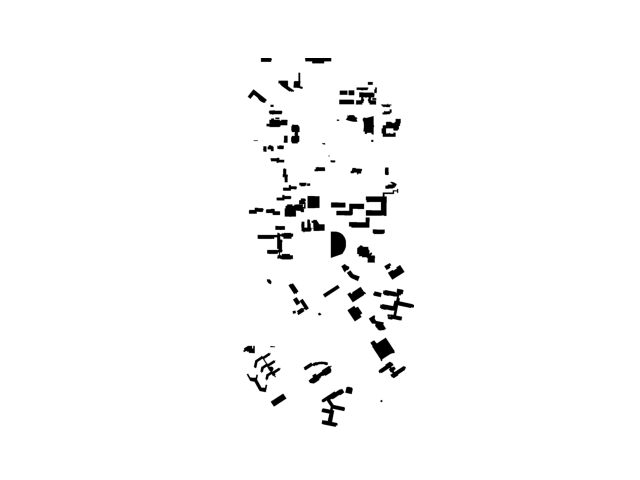

In [12]:

# plt.close("all")
fig, ax = plt.subplots()
ax.imshow(np.copy(maparray).astype(np.bool_), origin='lower', cmap='gray_r')
ax.axis('off')
fig.show()
